<a href="https://colab.research.google.com/github/uvinduuu/EMLEC-24/blob/main/HS2__Part3_Zero_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Shot Classification

## Overview
In this setup, we use a vision-language model named CLIP, that is trained on large internet scale data (~400 million image-text pairs). This model is trained with language prompts, meaning we can use language to ask the model questions.

We can show it an image, and a set of text prompts to which the model will select and return the matching text prompt. E.g. we give a photo of a cat & labels {cat, dog, bird, car}. The model will select dog as the correct label.

These kind of models can be very useful to work with in tasks where you do not want to perform any training. Also, these models can be fine-tuned on a specific dataset using the same linear probing strategy we tried out earlier.

## Exercise
In this exercise, we focus on zero-shot classification using CLIP. Fine-tuning under linear probe settings is left as an exercise for anyone interested.

## My points

Zero-shot learning (ZSL) is a machine learning paradigm where a model is trained to recognize classes (or categories) that it has never seen or been explicitly trained on during the training phase.

### Example Clarification:
Training Phase: Suppose you're training a ZSL model to recognize different bird species.

For each bird species, you provide a textual description of its attributes, such as "small, yellow belly, long tail" for one species, and "medium-sized, blue feathers, crest on head" for another.
Learning Phase: The model learns to map these textual descriptions to visual features extracted from images of birds and other classes.

Inference Phase:

When you present an image of a new bird species (not seen during training), the model uses its learned mapping between textual descriptions and visual features.
It infers the class of the new bird species based on the similarity between the visual features extracted from the image and the semantic attributes described in the textual descriptions learned during training.
Key Points:
Semantic Embeddings: Textual descriptions or attributes are used during training to create semantic embeddings that represent each class.
Mapping Textual to Visual Features: The model learns to map these semantic embeddings to visual features, enabling it to recognize new classes based on their visual similarity to learned attributes.
No Explicit Text with Images during Inference: During inference, you typically present only the image. The model internally references its learned semantic embeddings to classify the image based on its features.
In essence, ZSL leverages textual descriptions during training to create a robust understanding of class attributes, enabling the model to generalize to unseen classes during inference based on visual similarities to learned attributes rather than direct examples.

## Understanding Zero-shot Learning (ZSL):
####Training Phase:

During training, the ZSL model learns from:
Labeled images of several known dog breeds (e.g., Labrador Retriever, Poodle, German Shepherd).
Textual descriptions or attributes associated with some of these breeds (e.g., "medium-sized, curly fur" for Poodle, "large, athletic build" for Labrador Retriever).
Semantic Embeddings:

For the breeds where textual descriptions are provided, semantic embeddings or attributes are created. These embeddings represent the characteristics of each breed in a textual form.
Learning Semantic Associations:

The model learns to associate these semantic embeddings with visual features extracted from images of dog breeds.
This association process helps the model understand the relationship between textual descriptions (attributes) and visual characteristics of the dog breeds seen during training.
Inference Phase:
Scenario - Predicting Basenji:

During inference, you present an image of a Basenji breed to the ZSL model.
Basenji: A breed that was not explicitly seen during training with labeled images, and no specific textual description was provided during training for Basenji.
Process:

Visual Feature Extraction: The ZSL model extracts visual features from the image of the Basenji using the CNN component trained during the ZSL process.

Semantic Matching: Although no explicit textual description for Basenji was given during training, the model leverages its understanding of the textual descriptions (semantic embeddings) of other seen breeds.

For example, the model knows attributes like "medium-sized, short coat" from descriptions of breeds like Labrador Retriever or Beagle.
Inference Based on Similarity: When presented with the Basenji image, the model identifies visual features that resemble those seen in other breeds. It then matches these features to the closest learned semantic embeddings.

Even without a direct description for Basenji, the model uses its general understanding of dog breed characteristics to make an educated guess based on similarities in visual and attribute space.
Prediction Outcome:

Based on its learned associations and similarities with other breeds, the ZSL model predicts the class label for the Basenji image. It might label the Basenji as a "Hound" or "Terrier" based on perceived similarities in size, coat texture, and other visual attributes.

In [1]:
import torch
import torchvision

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wu7wmear
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wu7wmear
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
! mkdir datasets
! ls

datasets  sample_data


In [3]:
ds_train = torchvision.datasets.OxfordIIITPet(root="datasets", split="trainval", download=True)
ds_val = torchvision.datasets.OxfordIIITPet(root="datasets", split="test", download=True)

100%|██████████| 791918971/791918971 [00:07<00:00, 108251222.69it/s]


Extracting datasets/oxford-iiit-pet/images.tar.gz to datasets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 113002416.58it/s]


Extracting datasets/oxford-iiit-pet/annotations.tar.gz to datasets/oxford-iiit-pet


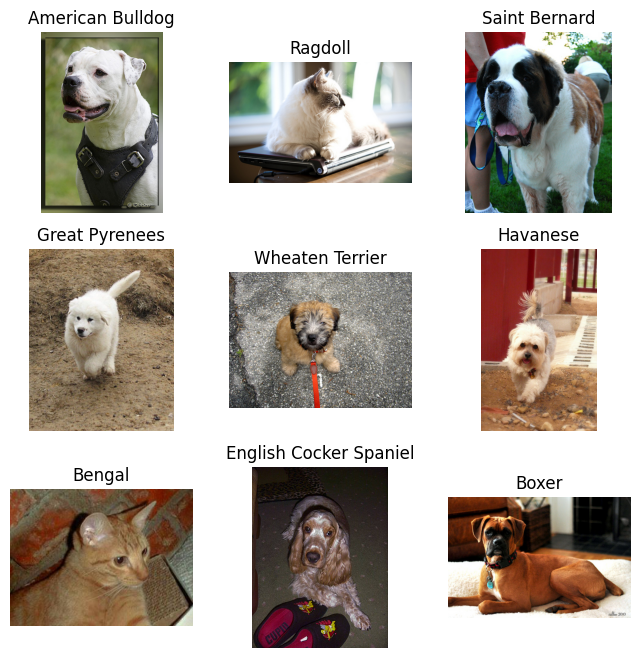

In [4]:
# let's first look at the data again
from matplotlib import pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds_train), size=(1,)).item()
    img, label = ds_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ds_train.classes[label])
    plt.axis("off")
    plt.imshow(np.array(img))
plt.show()

In [5]:
# load the CLIP model

import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:27<00:00, 12.7MiB/s]


In [6]:
for name, idx in ds_train.class_to_idx.items():
    assert ds_train.classes[idx] == name

In [7]:
ds_train.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [8]:
# convert all labels to embeddings - machine readable format conversion - tokenize
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of pet.") for c in ds_train.classes]).to(device)
# text_inputs = torch.cat([clip.tokenize(f"{c}, photo dog pet of a type a a .") for c in ds_train.classes]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_inputs.shape)

torch.Size([37, 77])


In [9]:
text_features.shape

torch.Size([37, 512])

In [10]:
text_inputs[7]

tensor([49406,   320,  1125,   539,   320, 23890,   267,   320,  3877,   539,
         3703,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)

Here we get the dot product of each image embedding with the text embedding, then the combination which giving the maximum value is the matching combination of text and image.

In [21]:
# process one image

sample_idx = 205
img, label = ds_train[sample_idx]

image = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

In [22]:
image_features.shape

torch.Size([1, 512])

Prediction for class Beagle: Bombay


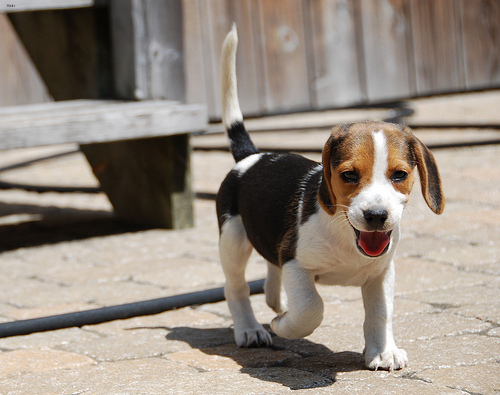

In [24]:
# let's see our prediction

'''for i in range(3):
  gt_annotation = ds_train.classes[label]
  prediction = ds_train.classes[indices[i].item()]
  print(f"Prediction for class {gt_annotation}: {prediction}")
  img'''

gt_annotation = ds_train.classes[label]
prediction = ds_train.classes[indices[i].item()]
print(f"Prediction for class {gt_annotation}: {prediction}")
img

In [25]:
# now let's run an entire evaluation

def test_model(dataset, model, text_features, verbose=False):
    size = len(dataset)
    correct = 0
    count = 0
    print(f"Running evaluation on {size} samples.")
    with torch.no_grad():
        for idx, (X, y) in enumerate(dataset):
            image = preprocess(X).unsqueeze(0).to(device)
            with torch.no_grad():
              image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)
            correct += (indices[0].item() == y)
            count += 1
            if verbose and idx % 100 == 0:
              print(100 * correct / count)

    correct /= size
    return correct

In [26]:
acc = test_model(ds_val, model, text_features, verbose=False)
print(f"CLIP acc on model: {acc * 100:.2f}")

Running evaluation on 3669 samples.
CLIP acc on model: 87.38
